### Moodboard on Playlists

In [171]:
!pip install requests --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
CLIENT_ID = '586ecea45142471cb181007f2ffe630b'
CLIENT_SECRET = '187ee73885934d9d86a78d4965b7d6d7'

In [173]:
auth_response = requests.post('https://accounts.spotify.com/api/token',
    {'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET}).json()
access_token = auth_response['access_token']
HEADERS = {'Authorization': 'Bearer {token}'.format(token=access_token)}

In [174]:
# Base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Id of playlist
# playlist_id = '37i9dQZF1DX4SBhb3fqCJd' 
playlist_id = '2kUlqhddlSFjPcY6FmK4qg' 
# https://open.spotify.com/playlist/5fu8CDQyQSx2dMyQpEnc7J?si=82f2411c9ab1436c
# https://open.spotify.com/playlist/4Hl2mw5rrOVPMJl2xqSFhV?si=46c790b82e9e4ce4

In [175]:
# https://open.spotify.com/playlist/5fu8CDQyQSx2dMyQpEnc7J?si=3de3bbe0447f49df
# https://open.spotify.com/playlist/5fu8CDQyQSx2dMyQpEnc7J?si=b2e44782f14e4cf8
#https://open.spotify.com/playlist/2kUlqhddlSFjPcY6FmK4qg?si=7b18038b19044718

## Return metadata from a given track

In [187]:
def get_track_data(track_id):
    """ Given track_id, returns a dictionary
        containing the track's catalog information
        (e.g. name, artists, genres) and audio feature
        metadata (e.g. tempo, key, energy).
    """
    # Get each track's audio features
    audio = requests.get(BASE_URL + 'audio-features/' + track_id,
                         headers=HEADERS).json()
    # Get each track's catalog information
    track = requests.get(BASE_URL + 'tracks/' + track_id,
                         headers=HEADERS).json()
    artists = []
    genres = []
    for artist in track['artists']:
        artist_id = artist['id']
        artist_genres = requests.get(BASE_URL + 'artists/' + artist_id,
                                     headers=HEADERS).json()['genres']
        artists.append(artist['name'])
        genres.append(artist_genres)
    genres = [item for sublist in genres for item in sublist] # Flatten list
    
    # Combine into one dictionary and return
    audio.update({
        'name': track['name'],
        'artists': artists,
        'genres': genres,
        'popularity': track['popularity'],
        'explicit': track['explicit']
    })
    return audio

In [188]:
# sample track to test function
sample_track_id = '1Ist6PR2BZR3n2z2Y5R6S1'
get_track_data(sample_track_id)

{'danceability': 0.566,
 'energy': 0.647,
 'key': 1,
 'loudness': -6.815,
 'mode': 0,
 'speechiness': 0.0335,
 'acousticness': 0.0477,
 'instrumentalness': 0,
 'liveness': 0.121,
 'valence': 0.22,
 'tempo': 111.96,
 'type': 'audio_features',
 'id': '1Ist6PR2BZR3n2z2Y5R6S1',
 'uri': 'spotify:track:1Ist6PR2BZR3n2z2Y5R6S1',
 'track_href': 'https://api.spotify.com/v1/tracks/1Ist6PR2BZR3n2z2Y5R6S1',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Ist6PR2BZR3n2z2Y5R6S1',
 'duration_ms': 264773,
 'time_signature': 4,
 'name': 'Summertime Sadness',
 'artists': ['Lana Del Rey'],
 'genres': ['art pop', 'pop'],
 'popularity': 76,
 'explicit': False}

## Represent the playlist in a DataFrame

In [189]:
def get_playlist_data(playlist_id):
    """ Given playlist_id, returns a pandas DataFrame
        containing information on each track.
    """
    playlist_length = 50
    data = [] # Will contain info about the tracks on the playlist
    counter = 0 # Number of tracks appended to data

    while counter < playlist_length:
        limit = min(50, playlist_length-counter)
        playlist = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks',
                                headers=HEADERS,
                                params={'limit': limit, 'offset': counter}).json()
        if counter==0:
            playlist_length = playlist['total']
        counter = min(counter+50, playlist_length) # Update counter
    
        for item in playlist['items']:
            data.append(get_track_data(item['track']['id']))
    df = pd.DataFrame(data)
    return df

In [190]:
playlist_df = get_playlist_data(playlist_id)
playlist_df.head(10) # View first 8 entries of dataframe

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit
0,0.895,0.309,10,-18.614,1,0.0911,0.9360,0.966000,0.0826,0.919,...,spotify:track:4RBVWdDXchRIX4n3Fpnzvy,https://api.spotify.com/v1/tracks/4RBVWdDXchRI...,https://api.spotify.com/v1/audio-analysis/4RBV...,153277,4,Teenage Dream x Put Your Records On,[Darcy Stokes],[],0,False
1,0.426,0.872,10,-3.322,1,0.1150,0.0191,0.000000,0.2690,0.608,...,spotify:track:0oigSejhoNen2EdNAIFcm5,https://api.spotify.com/v1/tracks/0oigSejhoNen...,https://api.spotify.com/v1/audio-analysis/0oig...,187693,4,Hollywood Baby,[100 gecs],"[bubblegum bass, hyper-rock, hyperpop, proto-h...",60,True
2,0.816,0.375,7,-8.053,1,0.0996,0.6070,0.000009,0.0933,0.615,...,spotify:track:451GvHwY99NKV4zdKPRWmv,https://api.spotify.com/v1/tracks/451GvHwY99NK...,https://api.spotify.com/v1/audio-analysis/451G...,191907,4,Banana Pancakes,[Jack Johnson],[neo mellow],71,False
3,0.378,0.638,10,-5.576,1,0.0750,0.0200,0.000077,0.0849,0.735,...,spotify:track:7a86XRg84qjasly9f6bPSD,https://api.spotify.com/v1/tracks/7a86XRg84qja...,https://api.spotify.com/v1/audio-analysis/7a86...,250627,4,We Are Young (feat. Janelle Monáe),"[fun., Janelle Monáe]","[baroque pop, metropopolis, afrofuturism, alte...",74,False
4,0.483,0.777,4,-5.049,1,0.0618,0.0170,0.000019,0.2090,0.572,...,spotify:track:1Pyxh8ERS8aouSSOQVvVsz,https://api.spotify.com/v1/tracks/1Pyxh8ERS8ao...,https://api.spotify.com/v1/audio-analysis/1Pyx...,252560,4,Sour Patch Kids,[Bryce Vine],[indie pop rap],0,True
5,0.787,0.655,6,-8.339,0,0.0431,0.2380,0.000171,0.1380,0.650,...,spotify:track:6shRGWCtBUOPFLFTTqXZIC,https://api.spotify.com/v1/tracks/6shRGWCtBUOP...,https://api.spotify.com/v1/audio-analysis/6shR...,208653,4,Upside Down,[Jack Johnson],[neo mellow],70,False
6,0.614,0.840,7,-5.355,1,0.1090,0.0436,0.000416,0.3000,0.524,...,spotify:track:4x0ZEnpVD3venpJfaKRYcB,https://api.spotify.com/v1/tracks/4x0ZEnpVD3ve...,https://api.spotify.com/v1/audio-analysis/4x0Z...,168962,4,Pickles from the Jar,[Courtney Barnett],"[art pop, australian indie, chamber pop, indie...",1,False
7,0.652,0.568,7,-8.205,1,0.0363,0.4820,0.000000,0.0945,0.856,...,spotify:track:07gqJjvwwuZ1assFLKbiNn,https://api.spotify.com/v1/tracks/07gqJjvwwuZ1...,https://api.spotify.com/v1/audio-analysis/07gq...,117667,4,Dance Music,[The Mountain Goats],"[anti-folk, chamber pop, folk punk, indie rock...",0,False
8,0.615,0.658,5,-7.299,1,0.0343,0.0960,0.000911,0.2050,0.293,...,spotify:track:3n69hLUdIsSa1WlRmjMZlW,https://api.spotify.com/v1/tracks/3n69hLUdIsSa...,https://api.spotify.com/v1/audio-analysis/3n69...,227080,4,Breezeblocks,[alt-J],"[indie rock, indietronica, modern alternative ...",71,False
9,0.517,0.481,5,-8.273,1,0.0272,0.0293,0.000018,0.0903,0.461,...,spotify:track:6JnufVNLIO5F5Lk4sEVLeI,https://api.spotify.com/v1/tracks/6JnufVNLIO5F...,https://api.spotify.com/v1/audio-analysis/6Jnu...,246973,4,Little Lion Man,[Mumford & Sons],"[modern folk rock, modern rock, neo mellow, st...",1,True


# Some data analysis to gain further insight into the data

## Finding the song that has the highest valence in the playlist 

In [191]:
# Sort the DataFrame by valence in descending order
sorted_playlist = playlist_df.sort_values(by='valence', ascending=False)

In [192]:
# Get the happiest song
highest_valence = sorted_playlist.head(1).reset_index()
print("Happiest Song:")
print(highest_valence[[ 'name', 'valence']])

Happiest Song:
     name  valence
0  Talent     0.97


### Look up the valence of a given song in the playlist

In [193]:
# lookup valence of a given song in the playlist
song_name = "Breezeblocks" # Replace with the song printed above

# Get the index of the song
index_of_song = playlist_df[playlist_df['name'] == song_name].index[0]

# Get the valence of the song
valence_of_song = playlist_df.loc[index_of_song, 'valence']

print(f"Valence of '{song_name}': {valence_of_song}")

Valence of 'Breezeblocks': 0.293


### Visualize artist counts of playlist

In [194]:
# Flatten into one list of all artist names
all_artists = [artist for artists in playlist_df['artists'] for artist in artists]
# Get counts of each artist using value_counts
artist_counts = pd.Series(all_artists).value_counts()
print(artist_counts)

Jack Johnson             3
Kid Quill                2
alt-J                    2
Natasha Bedingfield      2
Spose                    1
Bina Bianca              1
Ziggy Alberts            1
Lawrence                 1
The Chords               1
Katrina & The Waves      1
Mt. Joy                  1
The Avett Brothers       1
Royel Otis               1
Katie Lynne Sharbaugh    1
Akintoye                 1
Darcy Stokes             1
100 gecs                 1
Tai Verdes               1
Paula Fuga               1
Noah And The Whale       1
Neutral Milk Hotel       1
Mumford & Sons           1
The Mountain Goats       1
Courtney Barnett         1
Bryce Vine               1
Janelle Monáe            1
fun.                     1
sammy rash               1
dtype: int64


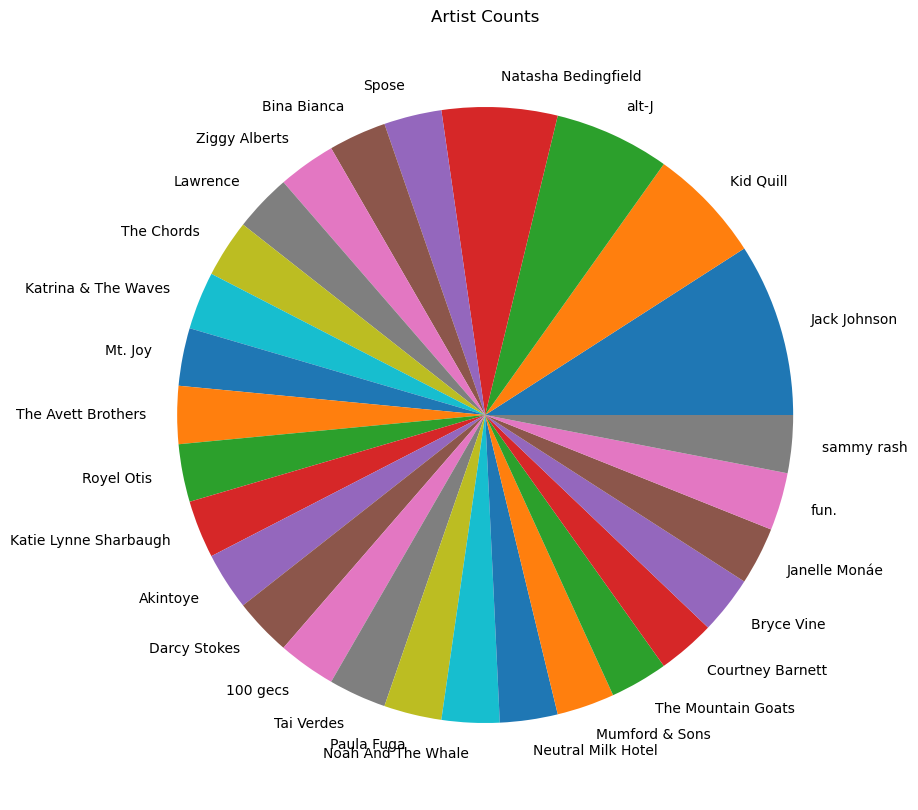

In [195]:
# represent visually
plt.figure(figsize=(10, 10))
# Type of graph (pie), specifying artist_counts as subject being graphed
plt.pie(artist_counts, labels=artist_counts.index)
# Give the plot a title
plt.title('Artist Counts')
# Show the plot
plt.show()

## See just the top 5 artists 

In [202]:
# Num of top artists
n = 5 
top_artists = artist_counts.head(n)
other_artists = artist_counts.iloc[n:].sum()
# Concatenate two Series
artist_counts_adjusted = pd.concat([top_artists, pd.Series({'Other': other_artists})])

# Uncomment the print statement if you'd like!
# print(artist_counts_adjusted)

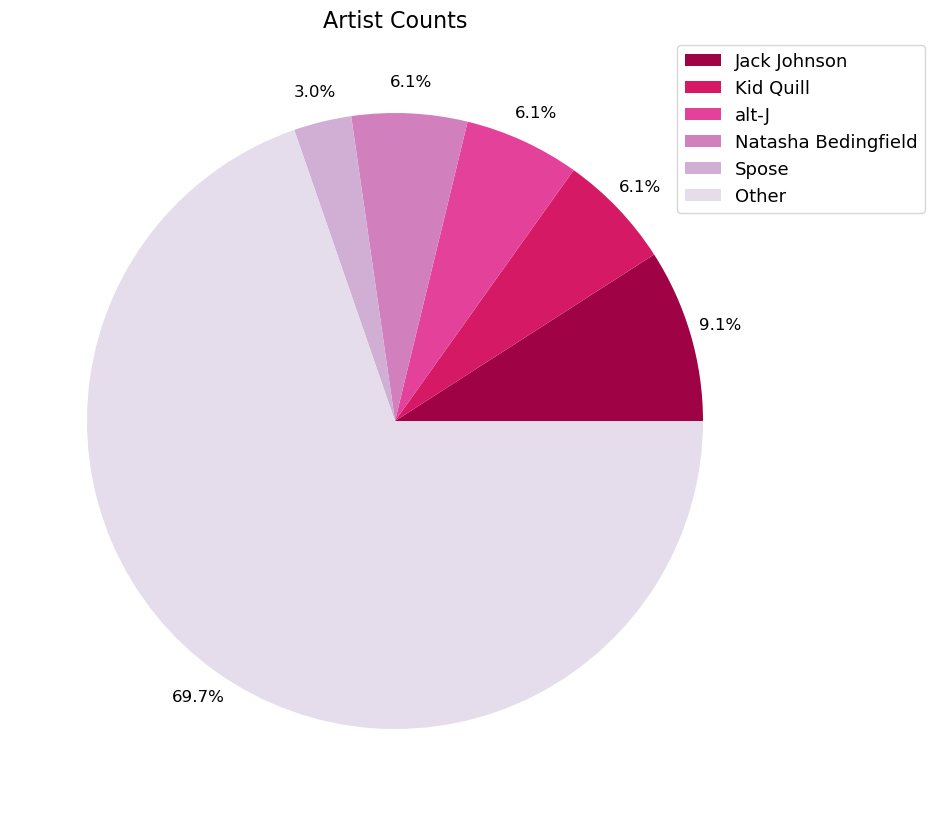

In [203]:
plt.figure(figsize=(10, 10))
plt.pie(
    artist_counts_adjusted, # Switched from artist_counts to artist_counts_adjusted
    autopct = '%.1f%%', # Displays percentage with 1 decimal place
    pctdistance = 1.1, # Relative distance of percentage from center of pie
    colors = sns.color_palette("PuRd_r"), # Apply seaborn color palette
    textprops = {'size': 12} # Font size
    )
plt.title(
    label = 'Artist Counts',
    fontdict={"fontsize":16} # Change font size of title
)
# Move labels to a legend
plt.legend(
    artist_counts_adjusted.index, 
    loc = "upper right", # Position of legend, relative to specified coordinates
    bbox_to_anchor = (1.2, 1), # Specify desired coordinates of legend
    prop = {'size': 13} # Font size
)
# Show the plot
plt.show()

### get key signature of a given song

In [185]:
# Define the key mapping, Numbers correspond to key signatures.
key_mapping = {
    0: 'C',
    1: 'C♯/D♭',
    2: 'D',
    3: 'D♯/E♭',
    4: 'E',
    5: 'F',
    6: 'F♯/G♭',
    7: 'G',
    8: 'G♯/A♭',
    9: 'A',
    10: 'A♯/B♭',
    11: 'B',
}

def get_song_info(df, song_name, info_key):
    """
    Given a DataFrame, song name, and desired information key,
    this function returns the desired feature of the given song.
    """
    # Encase in a try-catch so that if the song named is typed incorrectly 
    # or is not found within the df there won't be an error.
    try:
        # Case-insensitive search
        song_info_series = df[df['name'].str.lower() == song_name.lower()][info_key]
        if not song_info_series.empty:  # Check if the series is not empty
            song_info = song_info_series.values[0]  # Extract the first element
            return song_info
        else:
            print(f"Song '{song_name}' not found in the playlist.")
            return None
    except KeyError:
        print(f"Error: The column '{info_key}' does not exist in the DataFrame.")
        return None

In [196]:
# Test with the song Talent
song_name = "Talent"
info_key = "key"
song_key = get_song_info(playlist_df, song_name, info_key)

if song_key is not None: # "As long as the key is there"
    music_key = key_mapping.get(song_key, 'Note') # Call key mapping
    print(f'The key of "{song_name}" is {music_key}.')

The key of "Talent" is G.


### Visualizing how loud each song in the playlist is

In [198]:
# Sort values by loudness
loudness_sorted_df = playlist_df.sort_values(by='loudness')

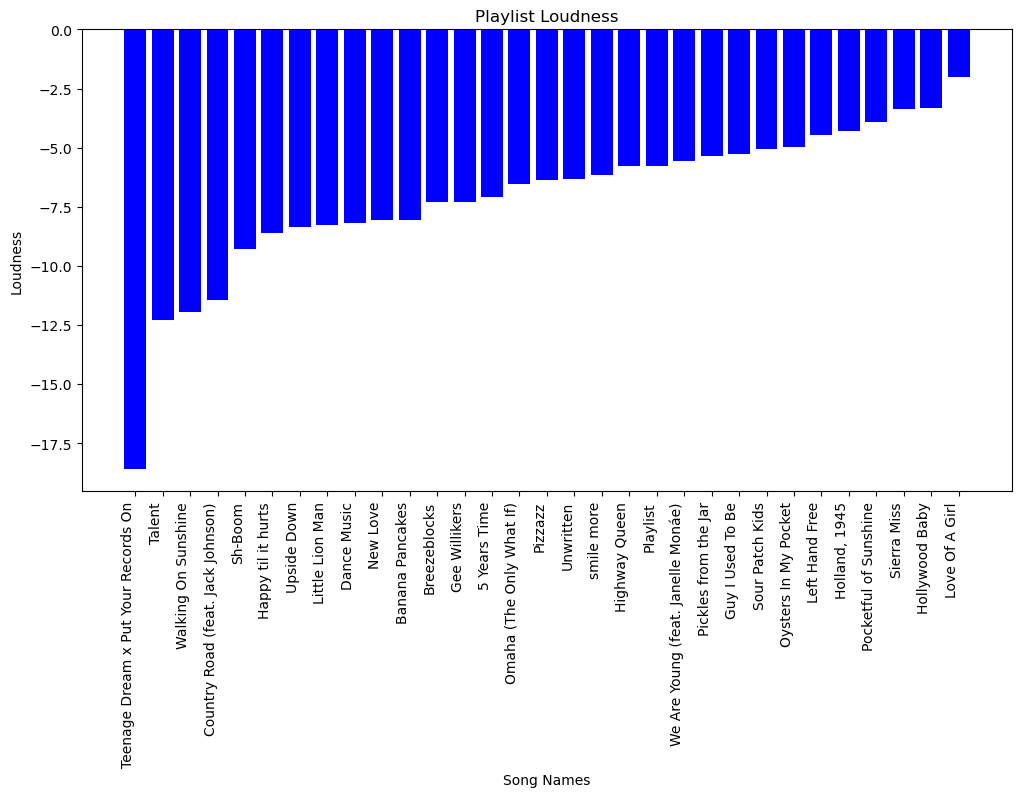

In [199]:
plt.figure(figsize=(12, 6))
plt.bar(loudness_sorted_df['name'], loudness_sorted_df['loudness'], color='blue')
plt.xlabel('Song Names')
plt.ylabel('Loudness')
plt.title('Playlist Loudness')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, ha='right') 
# Show the plot
plt.show()

## Is there any correlation between danceability and valence? 

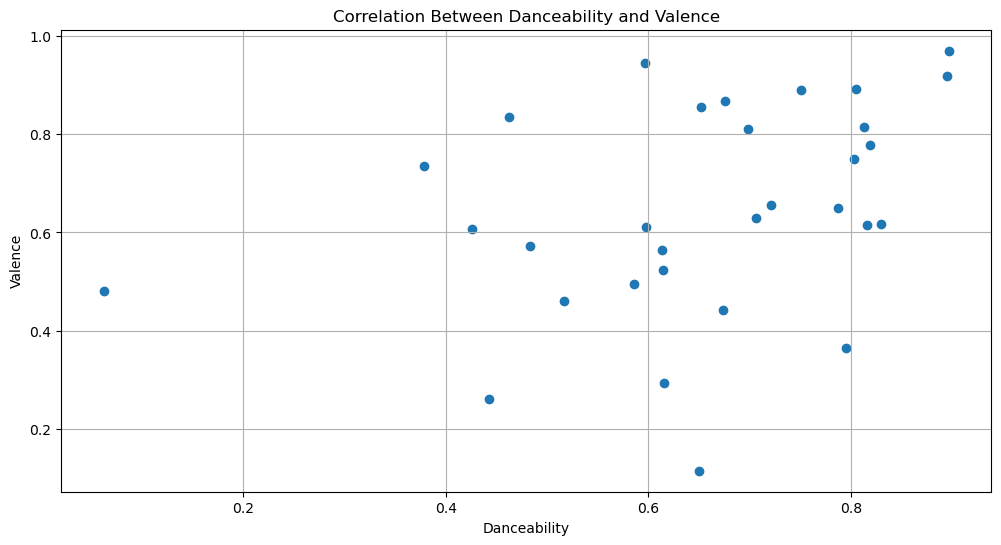

In [204]:
plt.figure(figsize=(12, 6))
# Plotting danceability and valence
plt.scatter(playlist_df['danceability'], playlist_df['valence'])
plt.title('Correlation Between Danceability and Valence')
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

In [205]:
correlation_coefficient = playlist_df['danceability'].corr(playlist_df['valence'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.3566783639213091


hmm. some degree of correlation. 

# Sentiment Analysis on the track names 

In [207]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [209]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to each tweet track name in playlist 
playlist_df['vader_score'] = playlist_df['name'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])

In [211]:
playlist_df.head(20)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit,vader_score
0,0.8950,0.309,10,-18.614,1,0.0911,0.9360,0.966000,0.0826,0.919,...,https://api.spotify.com/v1/tracks/4RBVWdDXchRI...,https://api.spotify.com/v1/audio-analysis/4RBV...,153277,4,Teenage Dream x Put Your Records On,[Darcy Stokes],[],0,False,0.2500
1,0.4260,0.872,10,-3.322,1,0.1150,0.0191,0.000000,0.2690,0.608,...,https://api.spotify.com/v1/tracks/0oigSejhoNen...,https://api.spotify.com/v1/audio-analysis/0oig...,187693,4,Hollywood Baby,[100 gecs],"[bubblegum bass, hyper-rock, hyperpop, proto-h...",60,True,0.0000
2,0.8160,0.375,7,-8.053,1,0.0996,0.6070,0.000009,0.0933,0.615,...,https://api.spotify.com/v1/tracks/451GvHwY99NK...,https://api.spotify.com/v1/audio-analysis/451G...,191907,4,Banana Pancakes,[Jack Johnson],[neo mellow],71,False,0.0000
3,0.3780,0.638,10,-5.576,1,0.0750,0.0200,0.000077,0.0849,0.735,...,https://api.spotify.com/v1/tracks/7a86XRg84qja...,https://api.spotify.com/v1/audio-analysis/7a86...,250627,4,We Are Young (feat. Janelle Monáe),"[fun., Janelle Monáe]","[baroque pop, metropopolis, afrofuturism, alte...",74,False,0.0000
4,0.4830,0.777,4,-5.049,1,0.0618,0.0170,0.000019,0.2090,0.572,...,https://api.spotify.com/v1/tracks/1Pyxh8ERS8ao...,https://api.spotify.com/v1/audio-analysis/1Pyx...,252560,4,Sour Patch Kids,[Bryce Vine],[indie pop rap],0,True,0.0000
5,0.7870,0.655,6,-8.339,0,0.0431,0.2380,0.000171,0.1380,0.650,...,https://api.spotify.com/v1/tracks/6shRGWCtBUOP...,https://api.spotify.com/v1/audio-analysis/6shR...,208653,4,Upside Down,[Jack Johnson],[neo mellow],70,False,0.0000
6,0.6140,0.840,7,-5.355,1,0.1090,0.0436,0.000416,0.3000,0.524,...,https://api.spotify.com/v1/tracks/4x0ZEnpVD3ve...,https://api.spotify.com/v1/audio-analysis/4x0Z...,168962,4,Pickles from the Jar,[Courtney Barnett],"[art pop, australian indie, chamber pop, indie...",1,False,0.0000
7,0.6520,0.568,7,-8.205,1,0.0363,0.4820,0.000000,0.0945,0.856,...,https://api.spotify.com/v1/tracks/07gqJjvwwuZ1...,https://api.spotify.com/v1/audio-analysis/07gq...,117667,4,Dance Music,[The Mountain Goats],"[anti-folk, chamber pop, folk punk, indie rock...",0,False,0.0000
8,0.6150,0.658,5,-7.299,1,0.0343,0.0960,0.000911,0.2050,0.293,...,https://api.spotify.com/v1/tracks/3n69hLUdIsSa...,https://api.spotify.com/v1/audio-analysis/3n69...,227080,4,Breezeblocks,[alt-J],"[indie rock, indietronica, modern alternative ...",71,False,0.0000
9,0.5170,0.481,5,-8.273,1,0.0272,0.0293,0.000018,0.0903,0.461,...,https://api.spotify.com/v1/tracks/6JnufVNLIO5F...,https://api.spotify.com/v1/audio-analysis/6Jnu...,246973,4,Little Lion Man,[Mumford & Sons],"[modern folk rock, modern rock, neo mellow, st...",1,True,0.0000


### Very strange that most of them are zero

In [212]:
# pull out top 5 highest vader scores

# Sort the DataFrame by 'vader_score' column in descending order
top_5_tracks = playlist_df.sort_values(by='vader_score', ascending=False).head(5)

# Select columns
top_5_tracks = top_5_tracks[['name', 'vader_score']]
print(top_5_tracks)


                     name  vader_score
16         Left Hand Free       0.7579
27               New Love       0.6369
20         Love Of A Girl       0.6369
24  Pocketful of Sunshine       0.4939
23    Walking On Sunshine       0.4939


In [215]:
# Compare this to the top 5 valence scores
top_5_valence = playlist_df.sort_values(by='valence', ascending=False).head(5)

# Select columns
top_5_valence = top_5_valence[['name', 'valence']]
print(top_5_valence)

                                   name  valence
29                               Talent    0.970
23                  Walking On Sunshine    0.944
0   Teenage Dream x Put Your Records On    0.919
27                             New Love    0.892
14                             Playlist    0.891


## Two of the top 5 positive sentiment scores are also two of the top 5 valence scores

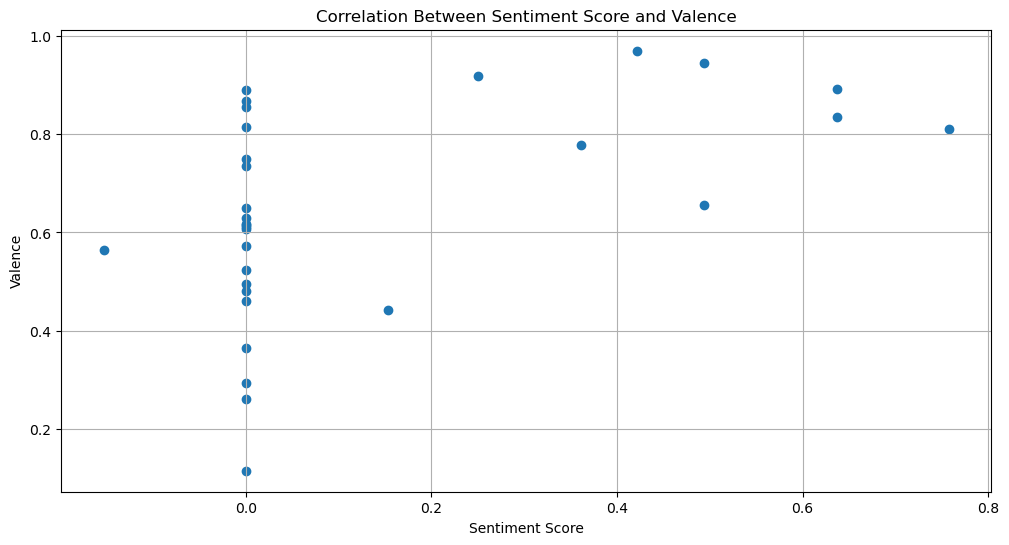

In [223]:
### Correlation between sentiment score and valence

plt.figure(figsize=(12, 6))
# Plotting danceability and valence
plt.scatter(playlist_df['vader_score'], playlist_df['valence'])
plt.title('Correlation Between Sentiment Score and Valence')
plt.xlabel('Sentiment Score')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

In [224]:
correlation_coefficient = playlist_df['vader_score'].corr(playlist_df['valence'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.5015219814527155


Moderate correlation between the two. 

## Because vader did not assign scores to every title, we'll use word embeddings and to find the cosine similarity between each title and 'happy'

In [228]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Load Word2Vec model
model = api.load("word2vec-google-news-300")

# Track names
track_names = playlist_df['name']

# Word to compare with
word_to_compare = "happy"

# Tokenize track names
tokenized_track_names = [name.lower().split() for name in track_names]

# Compute Word2Vec embeddings for each track name
track_name_embeddings = []
for tokens in tokenized_track_names:
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        track_name_embeddings.append(np.mean(embeddings, axis=0))
    else:
        track_name_embeddings.append(np.zeros(300))  # Use zero vector if no words found in model

# Compute Word2Vec embedding for the word "happy"
happy_embedding = model[word_to_compare]

# Calculate cosine similarity between "happy" and each track name
cos_similarities = cosine_similarity([happy_embedding], track_name_embeddings)

# Print cosine similarities
for track_name, cos_sim in zip(track_names, cos_similarities[0]):
    print(f"Cosine similarity between 'happy' and '{track_name}': {cos_sim}")


Cosine similarity between 'happy' and 'Teenage Dream x Put Your Records On': 0.2623475042494649
Cosine similarity between 'happy' and 'Hollywood Baby': 0.18675834228120036
Cosine similarity between 'happy' and 'Banana Pancakes': 0.1458604885247695
Cosine similarity between 'happy' and 'We Are Young (feat. Janelle Monáe)': 0.31931192156825583
Cosine similarity between 'happy' and 'Sour Patch Kids': 0.24465026489128236
Cosine similarity between 'happy' and 'Upside Down': 0.11530732628638443
Cosine similarity between 'happy' and 'Pickles from the Jar': 0.12915563633913985
Cosine similarity between 'happy' and 'Dance Music': 0.12277285743648453
Cosine similarity between 'happy' and 'Breezeblocks': 0.0
Cosine similarity between 'happy' and 'Little Lion Man': 0.24514166634672063
Cosine similarity between 'happy' and 'Holland, 1945': 0.0
Cosine similarity between 'happy' and '5 Years Time': 0.20324885543209145
Cosine similarity between 'happy' and 'Country Road (feat. Jack Johnson)': 0.132087

In [229]:
# Calculate cosine similarities
cos_similarities = cosine_similarity([happy_embedding], track_name_embeddings)[0]

# Find mean, max, and min
mean_cos_similarity = np.mean(cos_similarities)
max_cos_similarity = np.max(cos_similarities)
min_cos_similarity = np.min(cos_similarities)

print(f"Mean cosine similarity: {mean_cos_similarity}")
print(f"Max cosine similarity: {max_cos_similarity}")
print(f"Min cosine similarity: {min_cos_similarity}")


Mean cosine similarity: 0.19726241621914972
Max cosine similarity: 0.626340229585177
Min cosine similarity: 0.0


In [230]:
# Sort cosine similarities in descending order and get indices
top_5_indices = np.argsort(cos_similarities)[::-1][:5]

# Extract top 5 track names and their cosine similarities
top_5_track_names = [track_names[i] for i in top_5_indices]
top_5_cos_similarities = [cos_similarities[i] for i in top_5_indices]

# Print top 5 track names and their cosine similarities
print("Top 5 tracks with highest cosine similarities:")
for track_name, cos_sim in zip(top_5_track_names, top_5_cos_similarities):
    print(f"Track: {track_name}, Cosine Similarity: {cos_sim}")


Top 5 tracks with highest cosine similarities:
Track: Happy til it hurts, Cosine Similarity: 0.626340229585177
Track: New Love, Cosine Similarity: 0.36707484067287055
Track: We Are Young (feat. Janelle Monáe), Cosine Similarity: 0.31931192156825583
Track: smile more, Cosine Similarity: 0.30702185115594166
Track: Love Of A Girl, Cosine Similarity: 0.3028339528049282


In [231]:
# Assuming playlist_df is a DataFrame containing valence scores

# Get the valence scores of the top 5 tracks
top_5_valence_scores = playlist_df.loc[top_5_indices, 'valence']

# Print the top 5 track names, their cosine similarities, and their valence scores
print("Top 5 tracks with highest cosine similarities and their valence scores:")
for track_name, cos_sim, valence_score in zip(top_5_track_names, top_5_cos_similarities, top_5_valence_scores):
    print(f"Track: {track_name}, Cosine Similarity: {cos_sim}, Valence Score: {valence_score}")


Top 5 tracks with highest cosine similarities and their valence scores:
Track: Happy til it hurts, Cosine Similarity: 0.626340229585177, Valence Score: 0.443
Track: New Love, Cosine Similarity: 0.36707484067287055, Valence Score: 0.892
Track: We Are Young (feat. Janelle Monáe), Cosine Similarity: 0.31931192156825583, Valence Score: 0.735
Track: smile more, Cosine Similarity: 0.30702185115594166, Valence Score: 0.778
Track: Love Of A Girl, Cosine Similarity: 0.3028339528049282, Valence Score: 0.836


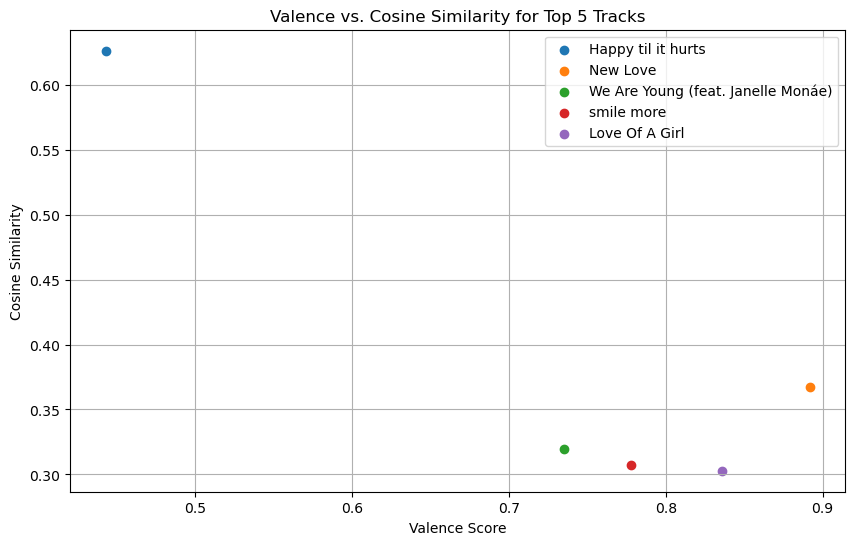

In [232]:
# Get the valence scores of all tracks
all_valence_scores = playlist_df['valence']

# Plot
plt.figure(figsize=(10, 6))

# Plot each track
for track_name, cos_sim, valence_score in zip(top_5_track_names, top_5_cos_similarities, top_5_valence_scores):
    plt.scatter(valence_score, cos_sim, label=track_name)

# Add labels and legend
plt.xlabel('Valence Score')
plt.ylabel('Cosine Similarity')
plt.title('Valence vs. Cosine Similarity for Top 5 Tracks')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [233]:
# Add cosine similarity scores as a new column to playlist_df
playlist_df['cosine_similarity'] = cos_similarities

correlation_coefficient = playlist_df['cosine_similarity'].corr(playlist_df['valence'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.04624440312478297


No correlation

# Taking the metadata and representing it as art

In [156]:
# find color pallete 
from pylab import *

cmap = cm.get_cmap('seismic', 5)  # matplotlib color palette name, n colors
for i in range(cmap.N):
    rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

cmap = cm.get_cmap('plasma', 101)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
print(color_list)

#00004c
#0000ff
#ffffff
#ff0000
#800000
['#0d0887', '#130789', '#1b068d', '#20068f', '#260591', '#2a0593', '#2f0596', '#330597', '#38049a', '#3e049c', '#41049d', '#46039f', '#4903a0', '#4e02a2', '#5102a3', '#5601a4', '#5901a5', '#5e01a6', '#6300a7', '#6600a7', '#6a00a8', '#6e00a8', '#7201a8', '#7501a8', '#7a02a8', '#7e03a8', '#8104a7', '#8606a6', '#8808a6', '#8d0ba5', '#8f0da4', '#9410a2', '#9613a1', '#9a169f', '#9e199d', '#a11b9b', '#a51f99', '#a72197', '#ab2494', '#ad2793', '#b12a90', '#b32c8e', '#b6308b', '#ba3388', '#bc3587', '#bf3984', '#c13b82', '#c43e7f', '#c6417d', '#c9447a', '#cc4778', '#cd4a76', '#d04d73', '#d24f71', '#d5536f', '#d6556d', '#d9586a', '#da5b69', '#dd5e66', '#df6263', '#e16462', '#e3685f', '#e56a5d', '#e76e5b', '#e87059', '#ea7457', '#eb7655', '#ed7a52', '#ef7e50', '#f0804e', '#f2844b', '#f3874a', '#f58b47', '#f68d45', '#f79143', '#f89540', '#f9983e', '#fa9c3c', '#fb9f3a', '#fca338', '#fca636', '#fdab33', '#fdae32', '#fdb22f', '#feb72d', '#feba2c', '#febe2a', '#

In [157]:
import matplotlib.colors as mcolors
import numpy as np

In [158]:
colors1 = ['#f7f4ed', '#f0c51c', '#ee7526', '#ef4255'] # Replace with your own

# Make a copy of colors1 array... more on why we do this later!
colors1_reverse = colors1[::]  
colors1_reverse.reverse()

In [159]:
# define num of bins for smoother gradient 
n_bins = len(colors1) * 200

In [160]:
# Creating a LinearSegmentedColormap 
def make_colormap(cmap_name, colors, num_bins=n_bins):
    """
    Given the name of colormap (string), a string list of colors in their hex values, and a number of bins
    (predetermined if not provided), generate, return, and display a colormap
    """
    # Generating a colormap
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=num_bins)

    # Create a one-dimensional array to serve as stand-in data so that the colormap may be displayed well
    gradient_multi = np.linspace(0, 1, 256)
    # Stacking one array on top of another to visually  thicken it
    gradient_multi = np.vstack((gradient_multi, gradient_multi)) 

    # Display colormap
    # Dpi = dots-per-inch (pixel density)
    plt.figure(figsize=(3, 1), dpi=300)  # 300 dpi is the ideal dpi for Spotify playlist covers *
    plt.imshow(gradient_multi, aspect='auto', cmap=cmap)
    plt.title(cmap_name)
    plt.axis('off')
    plt.colorbar()
    plt.show()
    
    return cmap

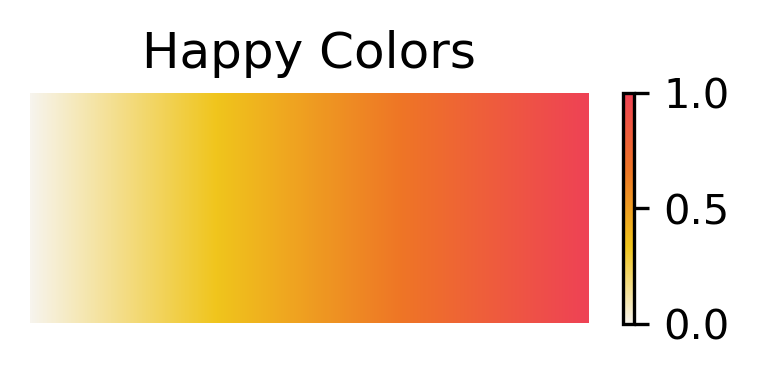

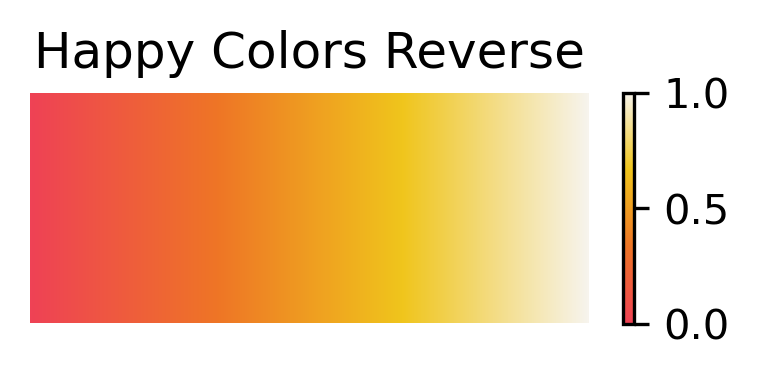

In [161]:
# Sample
cmap_name = 'Happy Colors'
happy_colors = make_colormap(cmap_name, colors1, n_bins)

cmap_name_reverse = 'Happy Colors Reverse'
happy_colors_reverse = make_colormap(cmap_name_reverse, colors1_reverse, n_bins)

In [162]:
figure_count = 0

def generate_artwork(df, x, y, cmap, weights):
    """
    Given a dataframe and the coordinates to be mapped onto the kernel density estimate (KDE) plot, generate a KDE
    plot to become the playlist art.
    """
    global figure_count
    
    plt.figure(figsize=(2, 2), dpi=300)
    fig = sns.kdeplot(data=df,       # Obtain data from the pandas dataframe provided
                x=x,                 # Choose variable and its corresponding data for x axis
                y=y,                 # Choose variable and its corresponding data for y axis
                cmap=cmap,           # Choose colormap to be used
                weights=weights,     # Choose data for which to weight the (x,y) coordinates
                thresh=0,            # 0 so as to display all data & not ignore any data
                levels=500,          # Similar to bins for a colormap; governs smoothness for KDE plot
                fill=True            # Fill in areas with no data
                )
    
    # Optionally, customize the plot with titles, labels, etc. 
#     plt.title('Playlist Aura')
#     plt.xlabel(x)
#     plt.ylabel(y)

    # Otherwise, comment out the above customization features & turn off the axis for just the image
    plt.axis('off')

    # Display & save the plot to local folder!
    plt.show()
    
    if figure_count == 0:
        figure_title = "Playlist Aura.png"
        fig.figure.savefig(figure_title, bbox_inches='tight')
    else:
        figure_title = "Playlist Aura(" + str(figure_count) + ").png"
        fig.figure.savefig(figure_title, bbox_inches='tight')
    # Global var to keep track of how many figures have bee created so the saved images don't overwrite each other
    figure_count += 1

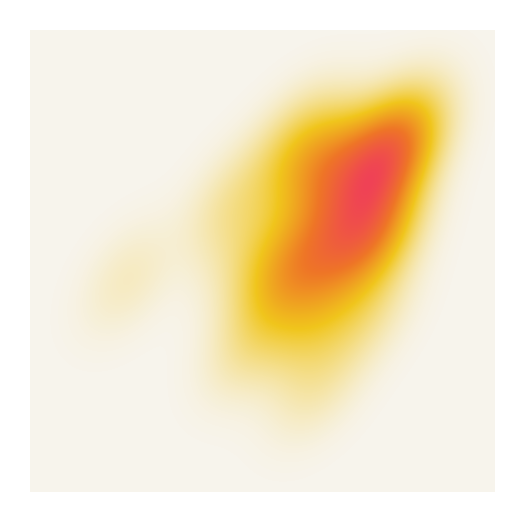

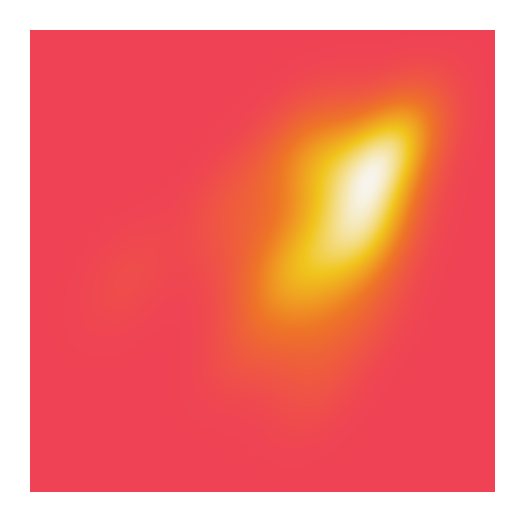

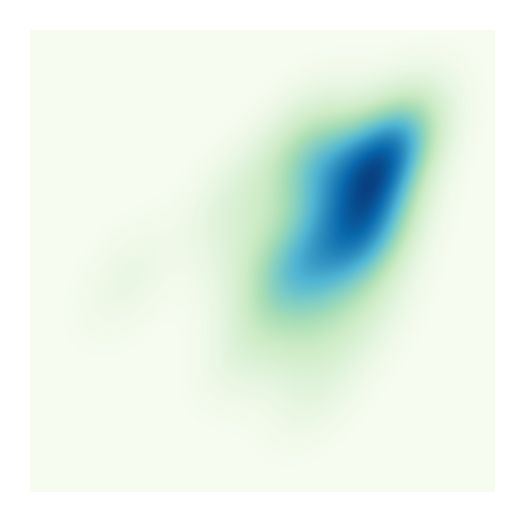

In [163]:
generate_artwork(playlist_df, "danceability", "valence", happy_colors, "loudness")
generate_artwork(playlist_df, "danceability", "valence", happy_colors_reverse, "loudness")
# GnBu is a mplt built-in colormap
generate_artwork(playlist_df, "danceability", "valence", "GnBu", "loudness") 

# Making the artwork more representative of the playlist

In [164]:
def classify_valence(df):
    total_valence = 0
    num_tracks = len(df)
    happy_scheme = ['#f7f4ed', '#f0c51c', '#ee7526', '#ef4255']
    mid_scheme = ['#b4cee1', '#f6f3ff', '#d2ede6', '#b6b864']
    sad_scheme = ['#571074', '#1a34b1', '#a1dbf1', '#1c4670']

    for valence in df['valence']:
        total_valence += valence

    avg_valence = total_valence / num_tracks

    if avg_valence > 0.6:
        # Happy Color scheme
        cmap_name = 'Playlist Mood'
        mood_plot = make_colormap(cmap_name, happy_scheme, n_bins)
        generate_artwork(wig_df, "danceability", "valence", mood_plot, "tempo") # add others
        
        
    elif 0.4 <= avg_valence <= 0.6:
        # mid color scheme
        cmap_name = 'Playlist Mood'
        mood_plot = make_colormap(cmap_name, mid_scheme, n_bins)
        generate_artwork(wig_df, "danceability", "valence", mood_plot, "loudness") # add others
        
    else:
        cmap_name = 'Playlist Mood'
        mood_plot = make_colormap(cmap_name, sad_scheme, n_bins)
        generate_artwork(wig_df, "danceability", "valence", mood_plot, "loudness") # add others
        
    

    print(avg_valence)

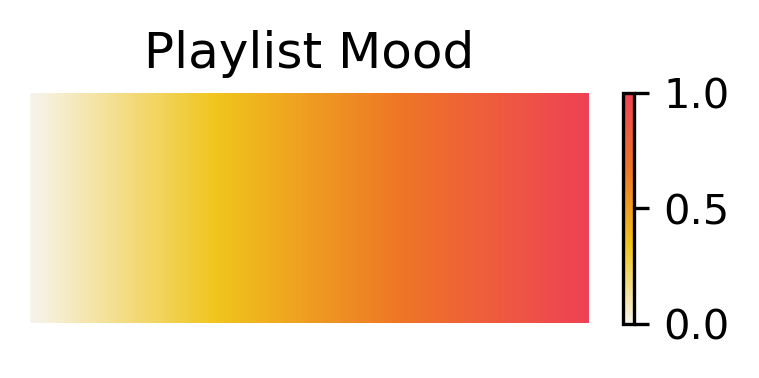

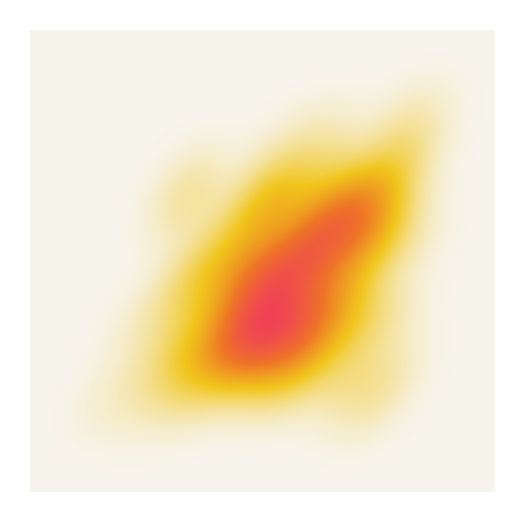

0.6458387096774193


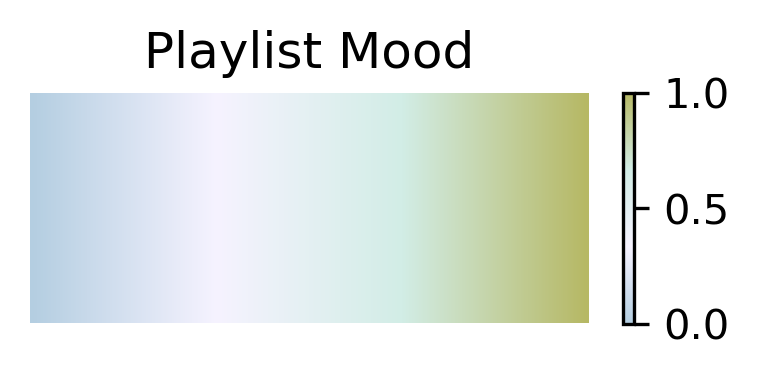

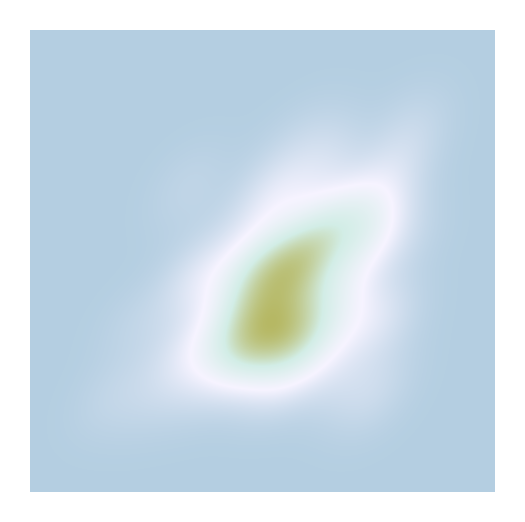

0.43945839416058374


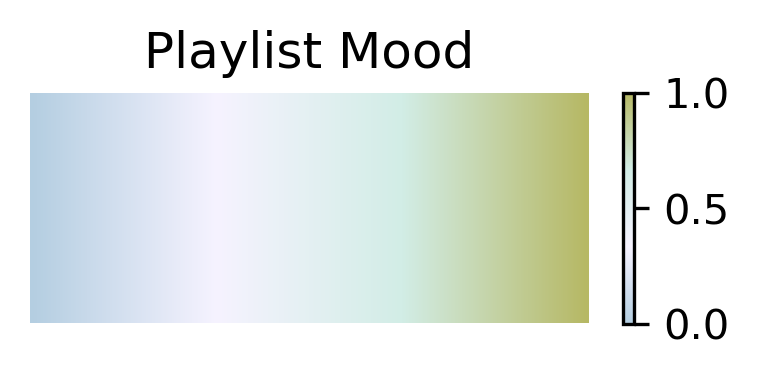

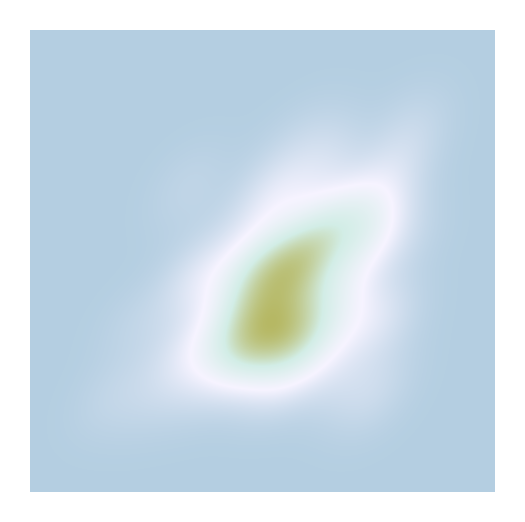

0.5969111111111112


In [170]:
classify_valence(playlist_df)
classify_valence(wig_df)
classify_valence(hap_df)

# Next Playlist

## wig one


In [166]:
playlist_id = '7fYwBA3tlbYZnKO4LPpUyT' 

In [167]:
playlist_id1 = '4oMLUsv1o6v4tIZ6jT6qXB'

In [168]:
hap_df = get_playlist_data(playlist_id1)
hap_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit
0,0.694,0.630,7,-6.840,0,0.1620,0.0998,0.000635,0.1200,0.341,...,spotify:track:6SkHm6poyKfzV6kc9any8k,https://api.spotify.com/v1/tracks/6SkHm6poyKfz...,https://api.spotify.com/v1/audio-analysis/6SkH...,189493,4,Suncity (feat. Empress Of),"[Khalid, Empress Of]","[pop, pop r&b, art pop, electropop, escape roo...",57,False
1,0.424,0.615,9,-6.217,0,0.0325,0.0158,0.000389,0.0844,0.155,...,spotify:track:5M4yti0QxgqJieUYaEXcpw,https://api.spotify.com/v1/tracks/5M4yti0QxgqJ...,https://api.spotify.com/v1/audio-analysis/5M4y...,318591,4,Eventually,[Tame Impala],"[australian psych, modern rock, neo-psychedeli...",77,False
2,0.945,0.702,11,-5.016,0,0.1200,0.5910,0.000538,0.0788,0.678,...,spotify:track:5bknBRjKJZ643DAN2w8Yoy,https://api.spotify.com/v1/tracks/5bknBRjKJZ64...,https://api.spotify.com/v1/audio-analysis/5bkn...,259000,4,FACE,[BROCKHAMPTON],"[boy band, rap]",60,True
3,0.652,0.595,11,-4.040,1,0.1130,0.1500,0.000115,0.0842,0.444,...,spotify:track:4uziEsK1yiqdauKVDPsmVG,https://api.spotify.com/v1/tracks/4uziEsK1yiqd...,https://api.spotify.com/v1/audio-analysis/4uzi...,150853,4,Rojo,[J Balvin],"[reggaeton, reggaeton colombiano, trap latino,...",63,False
4,0.582,0.404,2,-11.327,0,0.0413,0.8300,0.003080,0.1010,0.465,...,spotify:track:128I36bDgYHU9l2QcgEGcd,https://api.spotify.com/v1/tracks/128I36bDgYHU...,https://api.spotify.com/v1/audio-analysis/128I...,155083,4,Love Between...,[Kali Uchis],[colombian pop],62,False
5,0.799,0.539,1,-6.351,1,0.0421,0.1990,0.000017,0.1650,0.394,...,spotify:track:5Z3GHaZ6ec9bsiI5BenrbY,https://api.spotify.com/v1/tracks/5Z3GHaZ6ec9b...,https://api.spotify.com/v1/audio-analysis/5Z3G...,202547,4,Young Dumb & Broke,[Khalid],"[pop, pop r&b]",82,False
6,0.527,0.551,7,-11.258,1,0.0345,0.3840,0.000003,0.4030,0.443,...,spotify:track:3Pbp7cUCx4d3OAkZSCoNvn,https://api.spotify.com/v1/tracks/3Pbp7cUCx4d3...,https://api.spotify.com/v1/audio-analysis/3Pbp...,159636,4,Scared To Start,[Michael Marcagi],[],91,False
7,0.860,0.439,6,-12.264,0,0.0495,0.0204,0.014700,0.0465,0.725,...,spotify:track:7f9sC9fvtjYSZYOLSmKJlq,https://api.spotify.com/v1/tracks/7f9sC9fvtjYS...,https://api.spotify.com/v1/audio-analysis/7f9s...,228307,4,Tom's Diner,"[Suzanne Vega, DNA]","[lilith, new romantic, new wave pop, permanent...",57,False
8,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,...,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,Ain't No Sunshine,[Bill Withers],"[classic soul, funk, quiet storm, soul]",87,False
9,0.718,0.628,10,-6.007,0,0.2230,0.5430,0.000000,0.1160,0.722,...,spotify:track:2DgMxFMUQRPthW4ROhjen1,https://api.spotify.com/v1/tracks/2DgMxFMUQRPt...,https://api.spotify.com/v1/audio-analysis/2DgM...,274274,4,SWEET,[BROCKHAMPTON],"[boy band, rap]",58,True


In [169]:
wig_df = get_playlist_data(playlist_id)
wig_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit
0,0.380,0.0993,2,-20.567,1,0.0509,0.9140,0.000023,0.0605,0.440,...,spotify:track:18GiV1BaXzPVYpp9rmOg0E,https://api.spotify.com/v1/tracks/18GiV1BaXzPV...,https://api.spotify.com/v1/audio-analysis/18Gi...,165427,4,Blowin' in the Wind,[Bob Dylan],"[classic rock, country rock, folk, folk rock, ...",68,False
1,0.762,0.7010,8,-3.541,1,0.0286,0.2350,0.000158,0.1230,0.742,...,spotify:track:748mdHapucXQri7IAO8yFK,https://api.spotify.com/v1/tracks/748mdHapucXQ...,https://api.spotify.com/v1/audio-analysis/748m...,208867,4,Kiss Me More (feat. SZA),"[Doja Cat, SZA]","[dance pop, pop, pop, r&b, rap]",76,True
2,0.489,0.2560,5,-11.819,0,0.0322,0.7550,0.000010,0.1460,0.172,...,spotify:track:64lav7jWJqd5P4oWm4Ova6,https://api.spotify.com/v1/tracks/64lav7jWJqd5...,https://api.spotify.com/v1/audio-analysis/64la...,283827,3,Way Over Yonder,[Carole King],"[brill building pop, classic rock, folk, folk ...",45,False
3,0.570,0.3680,0,-9.128,1,0.0329,0.0514,0.000000,0.1080,0.136,...,spotify:track:3tzlgaWjqZJX0fq2hiQW62,https://api.spotify.com/v1/tracks/3tzlgaWjqZJX...,https://api.spotify.com/v1/audio-analysis/3tzl...,266668,4,Put Me in the Ground (feat. Austin Sawyer),"[Daniel Nunnelee, Austin Sawyer]",[nashville singer-songwriter],44,False
4,0.798,0.6770,0,-6.336,1,0.0628,0.1660,0.000000,0.1230,0.802,...,spotify:track:5XgX3D1i4B5Zbu3T33E0kw,https://api.spotify.com/v1/tracks/5XgX3D1i4B5Z...,https://api.spotify.com/v1/audio-analysis/5XgX...,169707,4,You Don't Have To Be A Prostitute,[Flight of the Conchords],"[comic, parody]",35,False
5,0.817,0.4950,9,-9.940,1,0.2380,0.6110,0.000000,0.1610,0.722,...,spotify:track:6889V4Hd6EQS0NblFkoleF,https://api.spotify.com/v1/tracks/6889V4Hd6EQS...,https://api.spotify.com/v1/audio-analysis/6889...,242160,4,The Most Beautiful Girl (In The Room),[Flight of the Conchords],"[comic, parody]",44,False
6,0.812,0.7690,6,-5.581,1,0.0442,0.0936,0.000000,0.0621,0.782,...,spotify:track:4O7caZhpneiM52gAlCsTpq,https://api.spotify.com/v1/tracks/4O7caZhpneiM...,https://api.spotify.com/v1/audio-analysis/4O7c...,162406,4,This View,[Surfaces],[bedroom soul],1,False
7,0.841,0.5020,6,-9.068,0,0.2110,0.5200,0.000187,0.1030,0.863,...,spotify:track:5GxUKIEkMXXZo1Tif0IzfC,https://api.spotify.com/v1/tracks/5GxUKIEkMXXZ...,https://api.spotify.com/v1/audio-analysis/5GxU...,224747,4,Two Moons,[BoyWithUke],[sad rap],67,True
8,0.642,0.5700,7,-12.557,1,0.0573,0.3220,0.008560,0.0626,0.611,...,spotify:track:0TsWu7ZYypXsIEIPwl6BOi,https://api.spotify.com/v1/tracks/0TsWu7ZYypXs...,https://api.spotify.com/v1/audio-analysis/0TsW...,193747,4,You Were,[Field Guide],[modern indie folk],50,False
9,0.550,0.6990,1,-3.635,1,0.1700,0.4350,0.000000,0.1970,0.697,...,spotify:track:0t9X8kIUL4QqoWq6HM5o2G,https://api.spotify.com/v1/tracks/0t9X8kIUL4Qq...,https://api.spotify.com/v1/audio-analysis/0t9X...,200080,4,Shit Show,[Peter McPoland],[pov: indie],52,True


In [27]:
# Visualize artist counts of playlist
# Flatten into one list of all artist names
all_artists = [artist for artists in wig_df['artists'] for artist in artists]
# Get counts of each artist using value_counts, a function provided by pandas
artist_counts = pd.Series(all_artists).value_counts()
print(artist_counts)

Rainbow Kitten Surprise    4
Mt. Joy                    4
Caamp                      4
alt-J                      3
The Avett Brothers         3
                          ..
James Ford Murphy          1
Napua Greig                1
Kuana Torres Kahele        1
Skylar Grey                1
Nabes                      1
Length: 129, dtype: int64


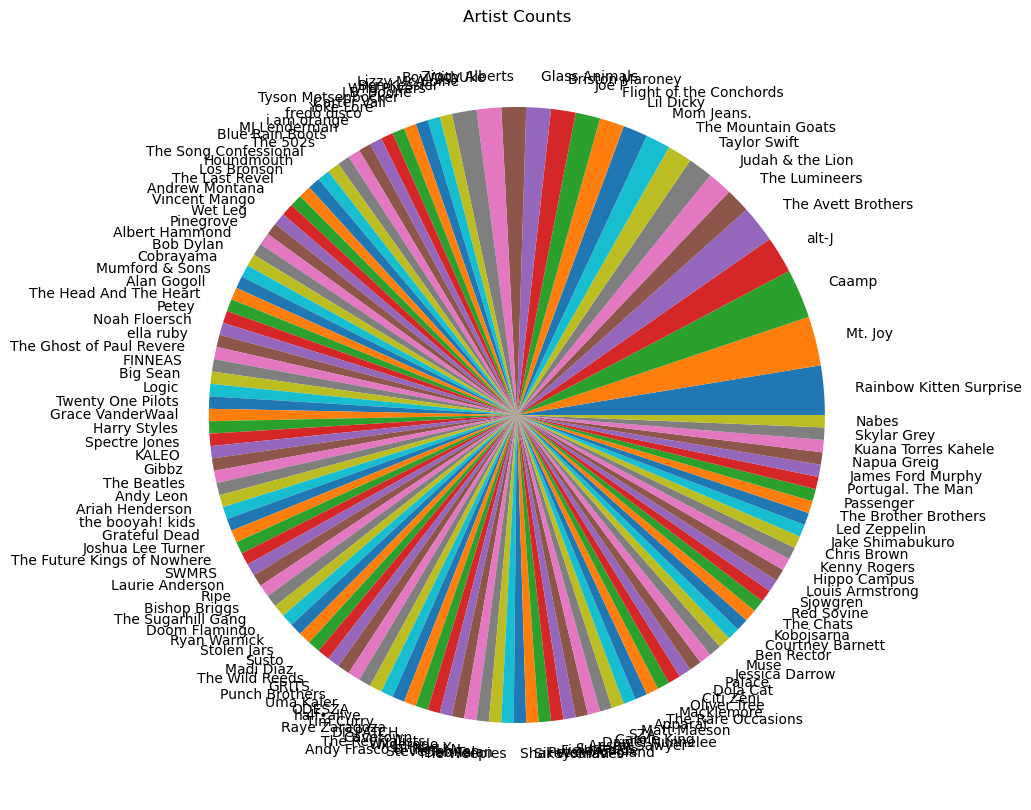

In [40]:
# Plot size
plt.figure(figsize=(10, 10))
# Type of graph (pie), specifying artist_counts as subject being graphed
plt.pie(artist_counts, labels=artist_counts.index)
# Give the plot a title
plt.title('Artist Counts')
# Show the plot
plt.show()